# C4dynamics

## 6 Degrees Of Freedom Example 

This notebook employs an example to illustrate the usage of C4dynamics to develop algorithms for missile guidance system. 

C4dynamics is a powerful framework for algorithm engineering that enables the creation of complex simulations with six degrees of freedom (6 DOF). With its advanced toolset, it allows for the creation of realistic and dynamic models that can be used to test and analyze various scenarios in fields such as robotics, aerospace, and mechanical engineering.

A 6 DOF simulation on top C4dynamics provides a comprehensive platform for exploring the movement and behavior of objects in 3D space. It includes features such as real-time rendering, physics simulation, and user interaction, allowing for a highly immersive and interactive experience. The simulation is built on top of the C4dynamics framework, which provides a robust and scalable infrastructure for developing and running algorithms.

In this demonstration, we will showcase the power and flexibility of C4dynamics by creating a 6 DOF simulation that demonstrates its ability to accurately model complex systems and provide real-time feedback. This will include an overview of the features and tools available in C4dynamics, as well as a hands-on demonstration of how to create and run a 6 DOF simulation. Whether you are a seasoned engineer or just starting out, this demonstration will provide valuable insights into the capabilities of the C4dynamics framework.



So, let's start: 

In [1]:
# user input

Nruns = 10 # 1000

Load third party modules 

In [2]:
# 
# updates may 2023
# fix large md
# ideal seeker? no change 
# ideal engine?
# ideal cas?
# ideal rocket. 
# ideal tgt. imporved 
# vm = 300 no 30. worse. 
# missile higher than target - imporved. 
##


# 
# see military handbook for missile flight simulation ch.12 simulation synthesis (205)
## 
import numpy as np
print(np.version.version)


import time
# import numpy as np
import sys, os, importlib
# from enum import Enum
from matplotlib import pyplot as plt



1.24.3


Load other modules that developed for the demonstration of current example 

In [3]:
import _control_system as mcontrol_system 
import _engine as mengine 
import _aerodynamics as maerodynamics

In [4]:
# !importc4d.py
# sys.path.append(os.path.join(os.getcwd(), '..'))
import c4dynamics as c4d
print(c4d.__version__)


1.0.50


Configure figure properties 

In [5]:

plt.rcParams["font.family"] = "Times New Roman" # "Britannic Bold" # "Modern Love"#  "Corbel Bold"# 
plt.rcParams["font.size"] = 20
plt.style.use('dark_background')  # 'default' # 'seaborn' # 'fivethirtyeight' # 'classic' # 'bmh'# plt.style.use('ggplot') # 
plt.rcParams['figure.figsize'] = (9.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
# plt.rcParams['text.usetex'] = True

Simulation setup

In [6]:

dt = 5e-3 
vm = 30


Objects definition 

In [7]:
target = c4d.datapoint(x = 4000, y = 1000, z = -3000
                        , vx = -250, vy = 0, vz = 0)

In [8]:
# for k in vars(target).keys():
#     print(k)
print(target._didx)

{'t': 0, 'x': 1, 'y': 2, 'z': 3, 'vx': 4, 'vy': 5, 'vz': 6}


The target is a datapoint object which means it has all the attributes of a mass in space:
Position: target.x, target.y, target.z
Velocity: target.vx, target.vy, target.vz
Acceleration: target.ax, target.ay, target.az
It also has mass: target.m (necessary for solving the equations of motion in the case of accelerating motion)

The target object in the example is initialized with initial position conditions in 3 axes and velocity conditions in the x-axis only. Acceleration is not initialized which is equivalent to zero initialization (default).
As the target in the example is non-accelerating it is not necessary to provide the mass with its instantiation.

In [9]:
missile = c4d.rigidbody(m = 85, iyy = 61, izz = 61, xcm = 1.55)

m0      = missile.mass
xcm0    = missile.xcm
i0      = missile.iyy

In [10]:
# print(missile._didx)
# print(target._didx)
# print(dir(missile))
# for a in dir(missile):
#     if not a.startswith('_'):
#         print(a)

In [11]:
# import numpy as np
# x = 10
# y = 15
# z = 20
# d = {'x': 0, 'y': 1, 'z': 2}

# v1 = np.empty(0)

# for k in d.keys():

#     v2 = eval(k)
#     v1 = np.hstack((v1, v2))

# print(missile.X)
print(np.array(missile.X))  # [np.ix_([0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14])])
print(missile.X[0 : 6] + missile.X[8 : 14])


[0 0 0 0 0 0 0 0 0 0 0 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


The missile is a rigid-body object which means that it has all the attributes of a datapoint but in addition:
Body angles: missile.phi, missile.theta, missile.psi (Euler)
Angular rates: missile.p, missile.q, missile.r (rotation about x-body, y-body, and z-body, respectively)
Angular accelerations: missile.p_dot, missile.q_dot, missile.r_dot (about x-body, y-body, and z-body, respectively)

As a rigid-body object it has also inertia attributes (necessary for solving the equations of motion in the case of accelerating motion):
Moment of inertia: missile.ixx, missile.iyy, missile.izz (about x-body, y-body, and z-body, respectively)
Distance from nose to center of mass: missile.xcm

The missile kinematic attributes in this example have not initialized with any initial conditions which mean that all its attributes are zero. But the mass properties provided as necessary. 
However, we will immediately see that the missile has initial kinematic conditions which are loaded through direct assignment and not by the class constructor (c4d.rigidbody()).

As the dynamics in this example involves a combustion of fuel of the rocket engine the missile’s mass attributes varying as function of time. To recalculate the mass during the run time it's a good advice to save these initial conditions. As iyy and izz are equal here it's enough to save just one of them.
In any way the initial position and attitude of anybody object (datapoint and rigid-body) is always saved with its instantiation 

The dimensions in this example are SI (i.e. seconds, meters, kilograms), but the objects and functions in the framework in general are independent of system of units. 

The example uses a line-of-sight seeker object from the c4dynamics' seekers module and controller, engine, and aerodynamics objects that developed for the purpose of this example:

In [12]:
seeker  = c4d.seekers.lineofsight(dt, tau1 = 0.01, tau2 = 0.01)
ctrl    = mcontrol_system.control_system(dt)
eng     = mengine.engine()
aero    = maerodynamics.aerodynamics()

# 6dof function

## Preliminary calculations

The initial missile pointing direction and angular rates are calculated in the fire-control block. 
For the example simulation, a simple algorithm is employed in which the missile is pointed directly at the target at the instant of launch, and missile angular rates at launch are assumed to be negligible.

The unit vector in the direction from the missile to the target is calculated by normalizing the range vector. 

## DCM
The function missile.BI is bounded method of the rigid-body class.
The function generates a Body from Inertial DCM (Direction Cosine Matrix) matrix in 3-2-1 order.
Using this matrix, the missile velocity vector in the inertial frame of coordinates is rotated to represent the velocity in the body frame of coordinates.

The inertial frame is determined by the frame that the initial Euler angles refer to.
In this example the Euler angles are with respect the x parallel to flat earth in the direction of the missile centerline, z positive downward, and y such that z completes a right-hand system.

The velocity vector is also produced by a bounded method of the class. The methods datapoint.pos, datapoint.vel, datapoint.acc read the current state of the object and return a three entries array composed of the coordinates of position, velocity, and acceleration, respectively. 

Similarly, the functions datapoint.P(), datapoint.V(), datapoint.A() return the object squared norm of the position, velocity, and acceleration, respectively.

## Main loop

The main loop includes the following steps: 

    Estimation of missile-target line-of-sight angular rate 
    Production of missile's wings-deflection commands 
    Calculation of missile's forces and moments 
    Integration of missile's equations of motion 
    Integration of target's equations of motion 
    Simulation update 


The simulation runs until one of the following conditions:
    The missile hits the ground
    The simulation time is over 


Comments are introduced inline.


In [13]:
def dof6sim(xtgt = 4000, tauseeker = 0.01, tauctrl = dt):

    #
    # define objects 
    ##
    missile = c4d.rigidbody()
    target  = c4d.datapoint(x = xtgt, y = 1000, z = -3000, vx = -250, vy = 0, vz = 0)
    seeker = c4d.seekers.lineofsight(dt, tau1 = 0.01, tau2 = tauseeker, ideal = False)
    ctrl   = mcontrol_system.control_system(tauctrl)
    eng    = mengine.engine()
    aero   = maerodynamics.aerodynamics()


    missile.mass   = m0   = 85         # initial mass, kg
    mbo         = 57                # burnout mass, kg 
    missile.xcm = xcm0 = 1.55       # nose to center of mass length, m
    xcmbo       = 1.35              # nose to cm after burnout, m
    missile.iyy = missile.izz = i0 = 61      
    ibo         = 47                # iyy izz at burnout 

    #
    # init
    #
    # The initial missile direction and angular rates are calculated in the fire-control block. 
    # For the example simulation, a simple algorithm is employed in which the missile is
    # pointed directly at the target at the instant of launch, and missile angular rates at launch are assumed to be negligible.
    # The unit vector uR in the direction from the missile to the target is calculated by normalizing the range vector R.
    ## 
    rTM           = target.pos - missile.pos
    rTMnorm        = np.linalg.norm(rTM)
    ucl           = rTM / rTMnorm # center line unit vector 
    missile.vx, missile.vy, missile.vz = vm * ucl 
    missile.psi   = np.arctan(ucl[1] / ucl[0])
    missile.theta = np.arctan(-ucl[2] / np.sqrt(ucl[0]**2 + ucl[1]**2))
    missile.phi   = 0
    u, v, w       = missile.BI @ missile.vel
    vc            = np.array([0, 0, 0])
    # these copy of md calc actually didnt change a bit in the results
    # bf = True # before flyby
    # rr = False # negative range rate flag

    alpha       = 0
    beta        = 0
    alpha_total = 0
    # alpha_total_data = alpha_total
    # prp_data = np.array([0, 0])

    # h = missile.z   # missile altitude above sea level, m
    d_pitch  = 0
    d_yaw    = 0

    ab_cmd = np.zeros(3)



    delta_data   = []
    omegaf_data  = []
    acc_data     = []
    aoa_data     = []
    moments_data = []


    t  = 0
    tf = 100 # 10 # 60

    h = -missile.z # missile altitude above sea level 


    while t <= tf and h >= 0 and vc[0] >= 0: # bf:

        #
        # atmospheric calculations    
        ##
        
        
        pressure, rho, vs = maerodynamics.aerodynamics.alt2atmo(h)
        
            
        mach = missile.V() / vs # mach number 
        Q = 1 / 2 * rho * missile.V()**2 # dynamic pressure 
        
        # 
        # relative position
        ##
        vTM = target.vel - missile.vel # missile-target relative velocity 
        rTM = target.pos - missile.pos # relative position 
        
        # # 
        # # miss distance 
        # ##       
        # rdot = (np.linalg.norm(rTM) - rTMnorm) / dt
        # if rr == False:
        #     if rdot < 0:
        #         rr = True;     # first time of negative range rate
        # else:
        #     if rdot >= 0:
        #         bf = False     # non-negative range rate after period of negative range rate
                
        #
        # relative velcoity
        ##
        rTMnorm = np.linalg.norm(rTM) # for next round 
        uR     = rTM / rTMnorm # unit range vector 
        vc     = -uR * vTM # closing velocity 
        
            


        # 
        # seeker 
        ## 
        wf = seeker.measure(rTM, vTM) # filtered los vector 
        omegaf_data.append([wf[1], wf[2]]) 
        
        # 
        # guidance and control 
        ##
        if t >= 0.5:
            Gs       = 4 * missile.V()
            acmd     = Gs * np.cross(wf, ucl)
            ab_cmd   = missile.BI @ acmd 
            afp, afy = ctrl.update(ab_cmd, Q)
            d_pitch  = afp - alpha 
            d_yaw    = afy - beta  
        # delta_data = np.vstack((delta_data, np.array([d_pitch, d_yaw])))
        
        acc_data.append(ab_cmd)
        delta_data.append([d_pitch, d_yaw])

        # 
        # missile dynamics 
        ##
        
        
        #
        # aerodynamics forces 
        ##    
        cL, cD = aero.f_coef(mach, alpha_total)
        L = Q * aero.s * cL
        D = Q * aero.s * cD
        
        A = D * np.cos(alpha_total) - L * np.sin(alpha_total) # aero axial force 
        N = D * np.sin(alpha_total) + L * np.cos(alpha_total) # aero normal force 
        
        fAb = np.array([ -A
                        , N * (-v / np.sqrt(v**2 + w**2))
                        , N * (-w / np.sqrt(v**2 + w**2))])
        fAe = missile.IB @ fAb
    
        # 
        # aerodynamics moments 
        ##
        cM, cN = aero.m_coef(mach, alpha, beta, d_pitch, d_yaw 
                            , missile.xcm, Q, missile.V(), fAb[1], fAb[2]
                                , missile.q, missile.r)
        
        
        mA = np.array([0                     # aerodynamic moemnt in roll
                    , Q * cM * aero.s * aero.d         # aerodynamic moment in pitch
                    , Q * cN * aero.s * aero.d])       # aerodynamic moment in yaw 

        moments_data.append(mA)
        # 
        # propulsion 
        ##
        thrust, thref = eng.update(t, pressure)
        fPb = np.array([thrust, 0, 0])# 
        # fPb = np.array([0, 0, 0])# 
        # prp_data = np.r_[prp_data, prp_data] doesnt work. bullshit. 
        # prp_data = np.vstack((prp_data, (thrust, thref))) 
        fPe = missile.IB @ fPb

        # 
        # gravity
        ## 
        fGe = np.array([0, 0, missile.mass * c4d.g_ms2])

        # 
        # total forces
        ##      
        forces = np.array([fAe[0] + fPe[0] + fGe[0]
                            , fAe[1] + fPe[1] + fGe[1]
                                , fAe[2] + fPe[2] + fGe[2]])
        
        # 
        # missile motion integration
        ##
        # missile.run(dt, forces, mA, t)
        missile.inteqm(forces, mA, dt)


        u, v, w = missile.BI @ np.array([missile.vx, missile.vy, missile.vz])
        
        # 
        # target dynmaics 
        ##
        target.inteqm(np.array([0, 0, 0]), dt)

        # 
        # update  
        ##
        t += dt
        missile.store(t)
        target.store(t)

        # v_data = np.vstack((v_data, np.array([u, v, w]))).copy()
        # aero_fm = np.vstack((aero_fm, np.concatenate((fAb, mA)))).copy()
        
        missile.mass -= thref * dt / eng.Isp        
        missile.xcm   = xcm0 - (xcm0 - xcmbo) * (m0 - missile.mass) / (m0 - mbo)
        missile.izz = missile.iyy = i0 - (i0 - ibo) * (m0 - missile.mass) / (m0 - mbo)

        alpha = np.arctan2(w, u)
        beta  = np.arctan2(-v, u)
        
        uvm = missile.vel / missile.V()
        ucl = np.array([np.cos(missile.theta) * np.cos(missile.psi)
                        , np.cos(missile.theta) * np.sin(missile.psi)
                        , np.sin(-missile.theta)])
        alpha_total = np.arccos(uvm @ ucl)
        # alpha_total_data = np.r_[alpha_total_data, alpha_total]# np.vstack((aero_fm, np.concatenate((fAb, mA)))).copy()
        aoa_data.append([alpha, beta, alpha_total])
        
        
        h = -missile.z

 
    # tfinal = t
    # md = np.linalg.norm(target.pos - missile.pos)
    vTM = target.vel - missile.vel # missile-target relative velocity 
    uvTM = vTM / np.linalg.norm(vTM)

    rTM = target.pos - missile.pos # relative position 

    md = np.linalg.norm(rTM - np.dot(rTM, uvTM) * uvTM)
    tfinal = t - np.dot(rTM, uvTM) / np.linalg.norm(vTM)


    return missile, target, md, tfinal \
                , (np.asarray(delta_data), np.asarray(omegaf_data)
                    , np.asarray(acc_data), np.asarray(aoa_data)
                        , np.asarray(moments_data))



The missile.run() function and the target.run() function perform integration of the equations of motion. 
The integration is performed by running Runge-Kutta of fourth order. 
For a datapoint, the equations are composed of translational equations, while for a datapoint they also include the rotational equations. 

Therefore, for a datapoint object, like the target in this example, a force vector is necessary for the evaluation of the derivatives. The force must be given in the inertial frame of reference. As the target in this example is not maneuvering, the force vector is [0, 0, 0].

For a rigid-body object, like the missile in this example, a force vector and moment vector are necessary for the evaluation of the derivatives. The force vector must be given in the inertial frame of reference. Therefore, the propulsion, and the aerodynamic forces are rotated to the inertial frame using the DCM321 missile.IB() function. The gravity forces are already given in the inertial frame and therefore remain intact. 

Forces and moments in the inertial frame are introduced to provide an estimation of the derivatives that represent the equations of motion. The integration method, 4th order Runge-Kutta is performed manually and independent on any third-party framework (such as scipy), therefore, currently, they may be non-optimal in terms of step-size variation. 
The choice of this is due to a feature which this framework desires to satisfy in which derivatives of two objects (such as missile and target) could be integrated simultaneously, with reciprocal dependent. 

Hopefully, later the function will be also optimized in terms of run-time and step-size variation.

In [14]:
'''
RUN SCRIPT
'''


# 
# user input
##
outfol = os.path.join('examples', 'out', 'dof6sim')
# print2file = printres.dynamics

cfile = os.path.join(outfol, 's6dout.txt')

if not os.path.exists(os.path.dirname(cfile)):
    os.makedirs(os.path.dirname(cfile))
else:
    if os.path.isfile(cfile):
        os.remove(cfile)

with open(cfile, 'at') as f:
    f.write('%-15s %-15s %-15s %-15s %-15s %-15s %-15s %-15s \n' 
        % ('tau seeker (s)', 'tau ctrl (s)', 'time (s)', 'position (m)', 'velocity (m/s)', 'acc (m/s^2)', 'miss distance (m)', 'flight time (s)'))

tauseeker0 = 2.0 # 0.01
tauctrl0 = 2.0 # 0.04

for tau in range(1): # Nruns): # (1000): 
    tauseeker = np.max((tauseeker0 + np.random.randn(), 0.01))
    tauctrl = np.max((tauctrl0 + np.random.randn(), 0.01))
    
    # print('taus ', tauseeker, ', tauc', tauctrl)
    tic = time.time()

    # missile, target, md, tfinal, data_arrays = dof6sim(tauseeker = tauseeker, tauctrl = tauctrl)
    missile, target, md, tfinal, data_arrays = dof6sim()
    
    # print('miss: %.2f, flight time: %.1f' % (md, tfinal))
    print('tauseeker: %.3f, tauctrl: %.3f, miss: %.5f, flight time: %.1f' % (tauseeker, tauctrl, md, tfinal))
    # print('total running time: ', time.time() - tic)

    delta_data  = data_arrays[0]
    omegaf_data = data_arrays[1]
    acc_data    = data_arrays[2]
    aoa_data    = data_arrays[3]
    moments_data = data_arrays[4]

    # if print2file: # print to file 
    with open(cfile, 'at') as f:

        pos_rel = np.linalg.norm(np.array([target.get_data('x') - missile.get_data('x')
                    , target.get_data('y') - missile.get_data('y')
                        , target.get_data('z') - missile.get_data('z')]).T
                            , ord = 2, axis = 1)
        vel_rel = np.linalg.norm(np.array([target.get_data('vx') - missile.get_data('vx')
                    , target.get_data('vy') - missile.get_data('vy')
                        , target.get_data('vz') - missile.get_data('vz')]).T
                            , ord = 2, axis = 1)
        # acc_rel = np.linalg.norm(np.array([target.get_data('ax') - missile.get_data('ax')
        #             , target.get_data('ay') - missile.get_data('ay')
        #                 , target.get_data('az') - missile.get_data('az')]).T
        #                     , ord = 2, axis = 1)
        
        tgtrng = np.sqrt(target.x0**2 + target.y0**2 + target.z0**2) * np.ones(pos_rel.shape).astype(int)

        md_vec = md * np.ones(pos_rel.shape)
        tf_vec = tfinal * np.ones(pos_rel.shape)


        np.savetxt(f, (np.array([tauseeker * np.ones(pos_rel.shape), tauctrl * np.ones(pos_rel.shape)
                        , missile.get_data('t'), pos_rel, vel_rel, md_vec, tf_vec]).T) 
                            , '%-15.3f %-15.3f %-15.4f %-15.0f %-15.0f %-15.6f %-15.3f')



warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - ex

warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - extraploation? 
warming - ex

about the datasave 

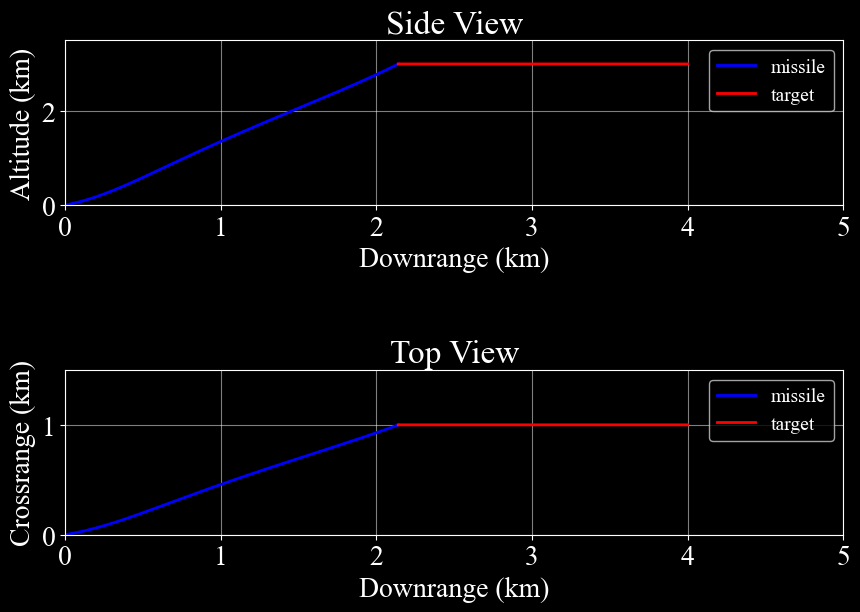

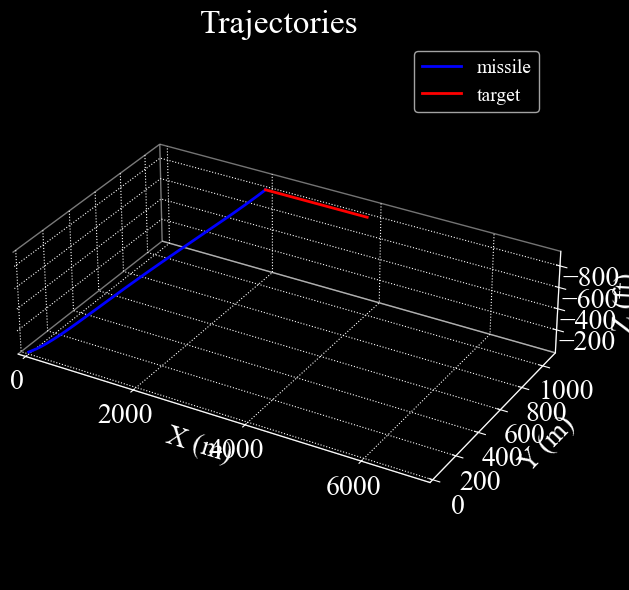

20.42172908782959


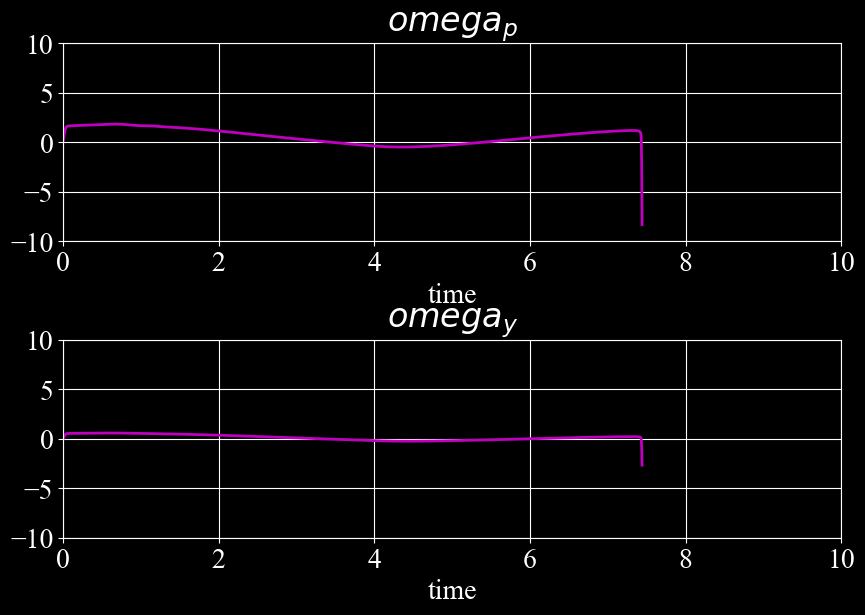

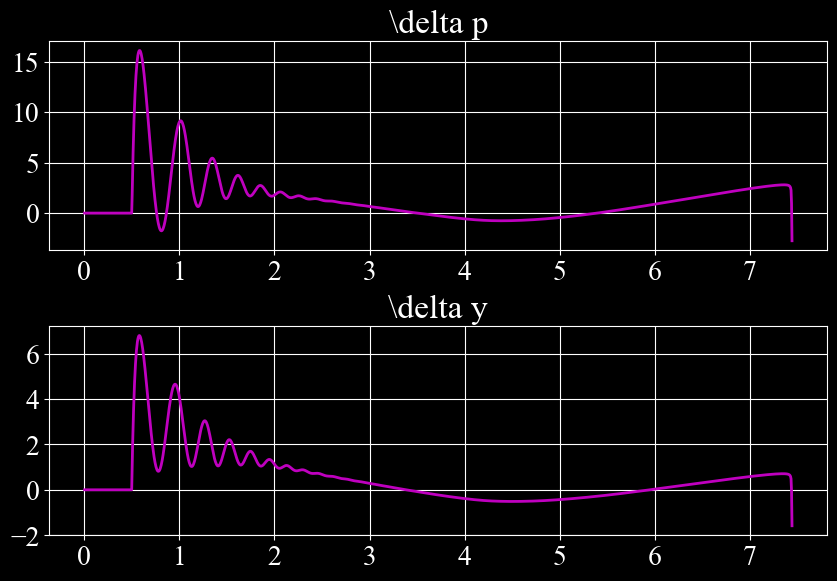

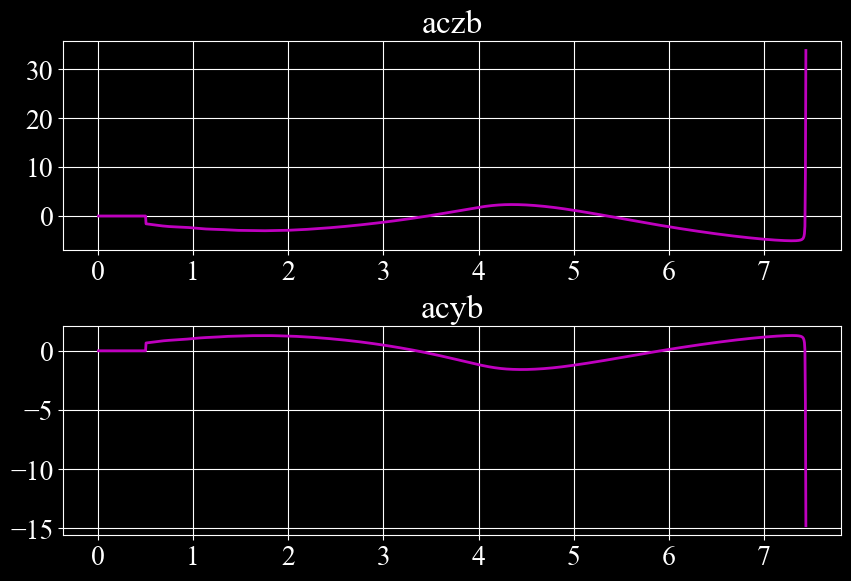

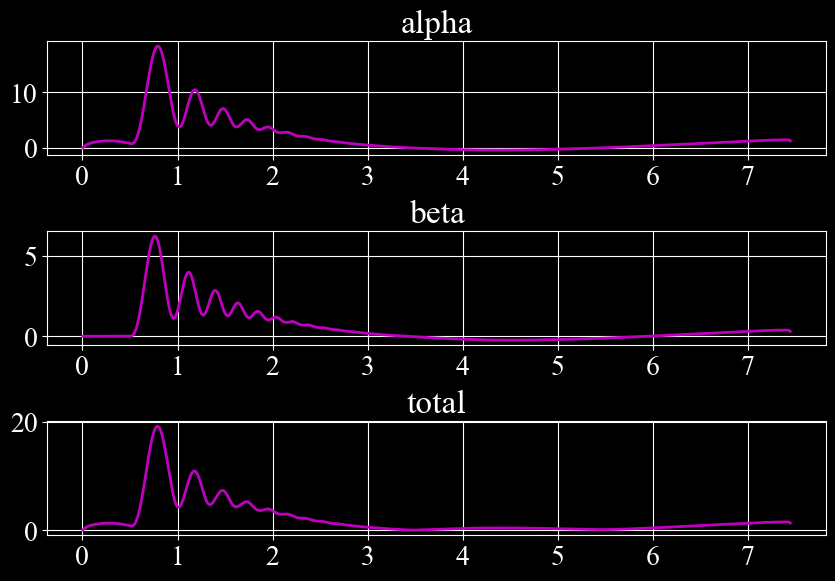

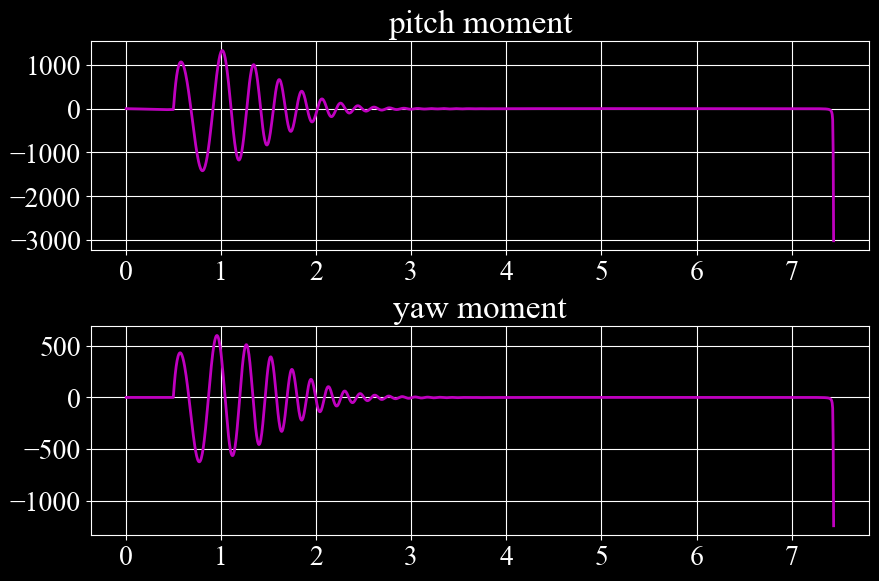

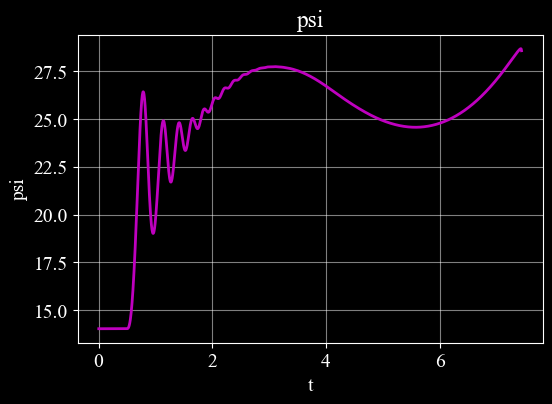

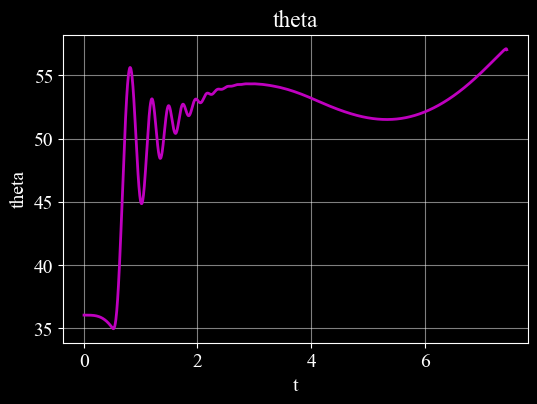

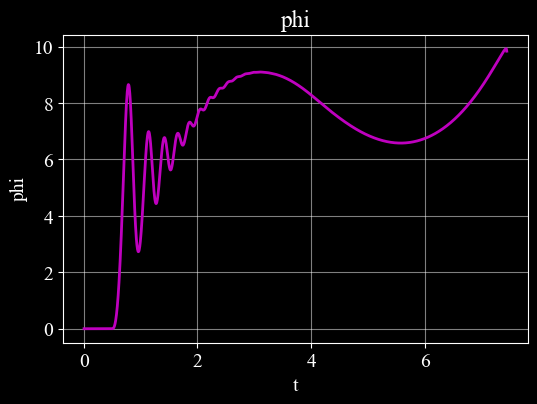

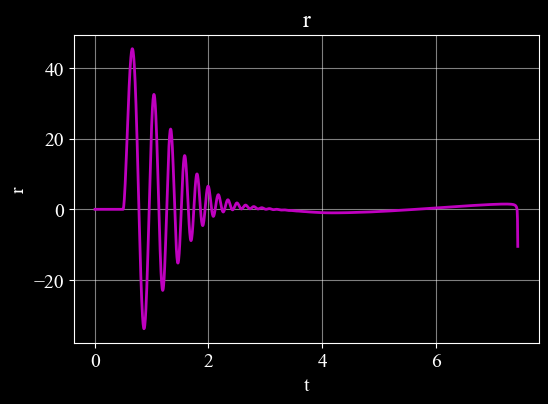

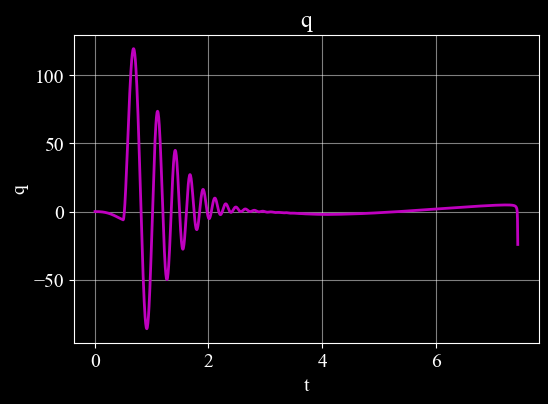

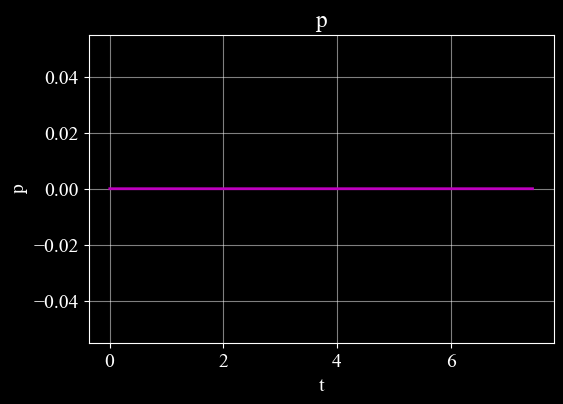

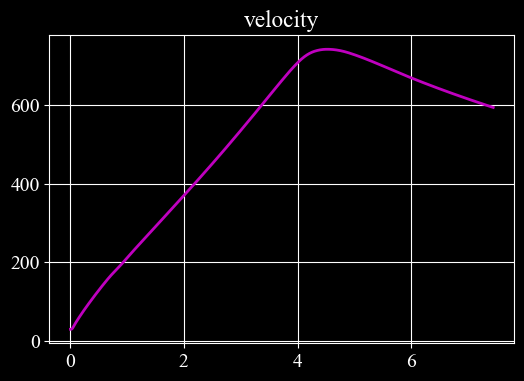

In [15]:

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

# 
# plt.show() plots all the figures present in the state machine. Calling it only at the end of 
#       the script, ensures that all previously created figures are plotted.
# Now you need to make sure that each plot indeed is created in a different figure. That can be 
#       achieved using plt.figure(fignumber) where fignumber is a number starting at index 1.
#



fig, (ax1, ax2) = plt.subplots(2, 1)
fig.tight_layout()

textcolor = 'white'

ax1.plot(missile.get_data('x') / 1000, -missile.get_data('z') / 1000, 'b', linewidth = 2, label = 'missile')
ax1.plot(target.get_data('x') / 1000, -target.get_data('z') / 1000, 'r', linewidth = 2, label = 'target')
ax1.set_title('Side View', color = textcolor)
ax1.set(xlabel = 'Downrange (km)', ylabel = 'Altitude (km)')
ax1.xaxis.label.set_color(textcolor)
ax1.yaxis.label.set_color(textcolor)
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 3.5)
ax1.grid(alpha = .5,  which = 'both', color = textcolor)
ax1.tick_params(axis = 'x', colors = textcolor)  # Change X-axis tick color to purple
ax1.tick_params(axis = 'y', colors = textcolor)  # Change X-axis tick color to purple
ax1.legend(fontsize = 14) # title = '#trk', loc = 'center left', bbox_to_anchor = (1, 0.5))

ax2.plot(missile.get_data('x') / 1000, missile.get_data('y') / 1000, 'b', linewidth = 2, label = 'missile')
ax2.plot(target.get_data('x') / 1000, target.get_data('y') / 1000, 'r', linewidth = 2, label = 'target')
ax2.set_title('Top View', color = textcolor)
ax2.set(xlabel = 'Downrange (km)', ylabel = 'Crossrange (km)')
ax2.xaxis.label.set_color(textcolor)
ax2.yaxis.label.set_color(textcolor)
ax2.set_xlim(0, 5)
ax2.set_ylim(0, 1.5)
ax2.grid(alpha = .5, which = 'both', color = textcolor)
ax2.tick_params(axis = 'x', colors = textcolor)  # Change X-axis tick color to purple
ax2.tick_params(axis = 'y', colors = textcolor)  # Change X-axis tick color to purple
ax2.legend(fontsize = 14) # title = '#trk', loc = 'center left', bbox_to_anchor=(1, 0.5))
# ax2.invert_yaxis()
plt.subplots_adjust(hspace = 1)
plt.savefig(os.path.join(outfol, 'trajectories.png'), format = 'png', transparent = True)





# plt.rcParams["font.family"] = "Times New Roman" # "Britannic Bold" # "Modern Love"#  "Corbel Bold"# 
# plt.rcParams["font.size"] = 20
# plt.style.use('dark_background')  # 'default' # 'seaborn' # 'fivethirtyeight' # 'classic' # 'bmh'# plt.style.use('ggplot') # 
# plt.rcParams['figure.figsize'] = (9.0, 6.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# # plt.rcParams['image.cmap'] = 'gray'
# # plt.rcParams['text.usetex'] = True
#
# 3d trajectories figure 
## 
# from mpl_toolkits.mplot3d import Axes3D
wfig = 12
hfig = 7
dfig = 3
 
fig = plt.figure(figsize = (wfig, hfig))
ax = fig.add_subplot(111, projection = '3d')
# Plot the trajectory
ax.plot(missile.get_data('x'), missile.get_data('y'), missile.get_data('z') * 0.3048, 'b', linewidth = 2, label = 'missile') # , color = '#2ECC71') # '#001F3F') # )
ax.plot(target.get_data('x'), target.get_data('y'), target.get_data('z') * 0.3048, 'r', linewidth = 2, label = 'target') # , color = '#E74C3C') # '#FF5733') # )
ax.set_title('Trajectories')
ax.set(xlabel = 'X (m)', ylabel = 'Y (m)', zlabel = 'Z (ft)')
ax.set_xlim(0, 7000)
ax.set_ylim(0, 1100)
ax.invert_zaxis()

ax.set_box_aspect([wfig, hfig, dfig])

ax.legend(fontsize = 14) # title = '#trk', loc = 'center left', bbox_to_anchor = (1, 0.5))
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# ax.grid(alpha = .1)
# Show the plot
# fig.set_size_inches(w, h)
ax.xaxis._axinfo["grid"]['linestyle'] = ":"
ax.yaxis._axinfo["grid"]['linestyle'] = ":"
ax.zaxis._axinfo["grid"]['linestyle'] = ":"
plt.savefig(os.path.join('examples', 'out', 'dof6sim_trajectories.png'), dpi = 72) 

plt.show()


# fig.tight_layout()
# plt.show()

# missile.draw('theta')

# target.draw('vx')
# target.draw('vy')

#
# total velocity 
# ##
# plt.figure()
# plt.plot(missile.get_data('t'), np.sqrt(missile.get_data('vx')**2 + missile.get_data('vy')**2 + missile.get_data('vz')**2))
# plt.title('Vm')
# plt.xlabel('t')
# plt.ylabel('m/s')
# plt.grid()
# plt.legend()

if True: 
    # 
    # omega los 
    ##
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.tight_layout()

    ax1.plot(missile.get_data('t'), omegaf_data[:, 0] * c4d.r2d, 'm', linewidth = 2)
    ax1.set_title('$omega_p$')
    ax1.grid()
    ax1.set_xlim(0, 10)
    ax1.set_ylim(-10, 10)
    ax1.set(xlabel = 'time', ylabel = '')

    ax2.plot(missile.get_data('t'), omegaf_data[:, 1] * c4d.r2d, 'm', linewidth = 2)
    ax2.set_title('$omega_y$')
    ax2.grid()
    ax2.set_xlim(0, 10)
    ax2.set_ylim(-10, 10)
    ax2.set(xlabel = 'time', ylabel = '')

    plt.subplots_adjust(hspace = 0.5)

    # 
    # wing deflctions
    ##
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.tight_layout()

    ax1.plot(missile.get_data('t'), delta_data[:, 0] * c4d.r2d, 'm', linewidth = 2)
    ax1.set_title('\delta p')
    ax1.grid()
    ax2.plot(missile.get_data('t'), delta_data[:, 1] * c4d.r2d, 'm', linewidth = 2)
    ax2.set_title('\delta y')
    ax2.grid()

    # 
    # body-frame acceleration cmds
    ##
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.tight_layout()

    ax1.plot(missile.get_data('t'), acc_data[:, 2] / c4d.g_ms2, 'm', linewidth = 2)
    ax1.set_title('aczb')
    ax1.grid()
    ax2.plot(missile.get_data('t'), acc_data[:, 1] / c4d.g_ms2, 'm', linewidth = 2)
    ax2.set_title('acyb')
    ax2.grid()

    # 
    # angles of attack
    ##
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    fig.tight_layout()

    ax1.plot(missile.get_data('t'), aoa_data[:, 0] * c4d.r2d, 'm', linewidth = 2)
    ax1.set_title('alpha')
    ax1.grid()
    ax2.plot(missile.get_data('t'), aoa_data[:, 1] * c4d.r2d, 'm', linewidth = 2)
    ax2.set_title('beta')
    ax2.grid()
    ax3.plot(missile.get_data('t'), aoa_data[:, 2] * c4d.r2d, 'm', linewidth = 2)
    ax3.set_title('total')
    ax3.grid()

    # 
    # body-frame acceleration cmds
    ##
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.tight_layout()

    ax1.plot(missile.get_data('t'), moments_data[:, 1], 'm', linewidth = 2)
    ax1.set_title('pitch moment')
    ax1.grid()
    ax2.plot(missile.get_data('t'), moments_data[:, 2], 'm', linewidth = 2)
    ax2.set_title('yaw moment')
    ax2.grid()

    # 
    # euler angles
    ##
    missile.draw('psi')
    missile.draw('theta')
    missile.draw('phi')

    # 
    # body rates 
    ##
    missile.draw('r')
    missile.draw('q')
    missile.draw('p')

    #
    # total velocity
    ##
    fig, ax1 = plt.subplots()
    V = np.sqrt(missile.get_data('vx')**2 + missile.get_data('vy')**2 + missile.get_data('vz')**2)
    ax1.plot(missile.get_data('t'), V, 'm', linewidth = 2)
    ax1.set_title('velocity')
    ax1.grid()





# # 
# # 3d plot
# ##

# fig = plt.figure()
# ax = plt.subplot(projection = '3d')
# # ax.invert_zaxis()

# plt.plot(missile._data[1:, 1], missile._data[1:, 2], missile._data[1:, 3] 
#         , 'm', linewidth = 2, label = 'missile')
# plt.plot(target._data[1:, 1], target._data[1:, 2], target._data[1:, 3]
#         , 'r', linewidth = 2, label = 'target')
    
print(time.time() - tic)

plt.show(block = True)
# plt.close('all')
    

    
    
    
    
    